In [1]:
import pandas as pd
import pyarrow.parquet as pq 
import numpy as np 

from sklearn.model_selection import train_test_split


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import numpy as np
import tensorflow as tf 
import random

tf.random.set_seed(123)
np.random.seed(123)
random.seed(123)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
filepath  = r'/kaggle/input/fever-nli/fr_fever-00000-of-00001-b7ec330d6224f90b.parquet'

In [4]:
table = pq.ParquetDataset(filepath)
df = table.read().to_pandas()

In [5]:
df.head(2)

,premise_original,hypothesis_original,label,premise,hypothesis
0,Islam . Sizable Muslim communities are also fo...,Islam does not have any followers.,2,Des communautés musulmanes considérables se tr...,L’islam n’a pas d’adeptes.
1,Gemini is a 2002 Indian Tamil-language action ...,Gemini is a movie that came out in 2002.,0,Gemini est un film d'action indien écrit et ré...,Gemini est un film sorti en 2002.


In [6]:
df_trans = df.drop(columns = ['label'], axis = 1)

In [7]:
df_trans.head(2)

,premise_original,hypothesis_original,premise,hypothesis
0,Islam . Sizable Muslim communities are also fo...,Islam does not have any followers.,Des communautés musulmanes considérables se tr...,L’islam n’a pas d’adeptes.
1,Gemini is a 2002 Indian Tamil-language action ...,Gemini is a movie that came out in 2002.,Gemini est un film d'action indien écrit et ré...,Gemini est un film sorti en 2002.


In [8]:
english_premises = df_trans['premise_original'].values
english_premises = english_premises.tolist()
print(english_premises[0])
english_hypothesis = df_trans['hypothesis_original'].values
english_hypothesis = english_hypothesis.tolist()
print(english_hypothesis[0])

Islam . Sizable Muslim communities are also found in the Americas , Caucasus , China , Europe , Mainland Southeast Asia , Philippines and Russia .
Islam does not have any followers.


In [9]:
french_premises_ref = df_trans['premise'].values
french_premises_ref = french_premises_ref.tolist()
french_hypothesis_ref = df_trans['hypothesis'].values
french_hypothesis_ref = french_hypothesis_ref.tolist()

In [10]:
import re
def preprocess_text(text):
    # Step 1: Lowercasing
    text = text.lower()
    # Step 2: Removing special characters and punctuation
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    # Step 3: Removing extra whitespaces
    text = re.sub(r"\s+", " ", text).strip()
    return text

 # Preprocess the input sentences
preprocessed_english_premises = [preprocess_text(sentence) for sentence in english_premises]


In [11]:
#Splitting the data

english_train, english_test, french_train, french_test = train_test_split(preprocessed_english_premises, french_premises_ref, test_size=0.2, random_state=42)

In [12]:
#Predicting one sentence
import tensorflow as tf
from transformers import TFAutoModelForSeq2SeqLM, AutoTokenizer

# Load pre-trained model and tokenizer for translation
model_name = "Helsinki-NLP/opus-mt-en-fr"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_name)

french_premises = []

# English sentence to be translated
#english_sentence = "Hello, how are you?"

# Tokenize input sentence
for premise in english_premises[:3]:
    # Tokenize input sentence
    inputs = tokenizer(premise, truncation=True, padding=True, return_tensors="tf")

    # Perform translation
    outputs = model.generate(inputs["input_ids"])
    french_ids = outputs[0].numpy()

    # Decode translated sentence
    french_sentence = tokenizer.decode(french_ids, skip_special_tokens=True)
    french_premises.append(french_sentence)

# Print the translated sentences
print("English premise:", english_premises[2])
print("French premise:", french_premises[2])
print()

/opt/conda/lib/python3.10/site-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


All model checkpoint layers were used when initializing TFMarianMTModel.

All the layers of TFMarianMTModel were initialized from the model checkpoint at Helsinki-NLP/opus-mt-en-fr.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.


/opt/conda/lib/python3.10/site-packages/transformers/generation/tf_utils.py:854: UserWarning: Using `max_length`'s default (512) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


English premise: Theodore John Kaczynski ( [ kəˈzɪnski ] born May 22 , 1942 ) , also known as the `` Unabomber '' , is an American serial killer , domestic terrorist , and self-professed anarchist .
French premise: Theodore John Kaczynski (né le 22 mai 1942 ), également connu sous le nom d'"Unabomber", est un tueur en série américain, un terroriste domestique et un anarchiste autoprofessé.



In [14]:
from transformers import TFAutoModelForSeq2SeqLM, AutoTokenizer, AdamWeightDecay
import tensorflow as tf

model_name = "Helsinki-NLP/opus-mt-en-fr"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenize inputs and outputs
inputs = tokenizer(english_train[:20000], truncation=True, padding=True, return_tensors="tf")
outputs = tokenizer(french_train[:20000], truncation=True, padding=True, return_tensors="tf")

# Create a function that will transform our dataset
def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

# Create tf.data.Datasets
BATCH_SIZE = 16
tf_train_dataset = tf.data.Dataset.from_tensor_slices((inputs['input_ids'], inputs['attention_mask'], outputs['input_ids']))
tf_train_dataset = tf_train_dataset.map(map_func).shuffle(10000).batch(BATCH_SIZE)

tf_test_dataset = tf.data.Dataset.from_tensor_slices((inputs['input_ids'], inputs['attention_mask'], outputs['input_ids']))
tf_test_dataset = tf_test_dataset.map(map_func).batch(BATCH_SIZE)

optimizer = AdamWeightDecay(learning_rate=2e-5, weight_decay_rate=0.01)

model = TFAutoModelForSeq2SeqLM.from_pretrained(model_name)
model.compile(optimizer=optimizer)
model.fit(tf_train_dataset, validation_data=tf_test_dataset, epochs=3)


/opt/conda/lib/python3.10/site-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
All model checkpoint layers were used when initializing TFMarianMTModel.

All the layers of TFMarianMTModel were initialized from the model checkpoint at Helsinki-NLP/opus-mt-en-fr.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.


Epoch 1/3
1250/1250 [==============================] - 1133s 876ms/step - loss: 1.3070 - val_loss: 0.6232
Epoch 2/3
1250/1250 [==============================] - 1055s 844ms/step - loss: 0.6403 - val_loss: 0.3925
Epoch 3/3
1250/1250 [==============================] - 1057s 845ms/step - loss: 0.4579 - val_loss: 0.2833


In [15]:
save_directory = "/kaggle/working"  # Specify the directory to save the model

# Save the model and tokenizer
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

print("Model saved successfully.")

Model saved successfully.


In [24]:
#predicting the sentences
import tensorflow as tf
#from transformers import TFBertModel, BertTokenizer
from transformers import TFAutoModelForSeq2SeqLM, AutoTokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from transformers import TFAutoModelForSeq2SeqLM, AutoTokenizer
from tensorflow.keras.optimizers import Adam

#saved_directory = "/kaggle/working"  # Specify the directory where the model was saved

# model = TFBertModel.from_pretrained(saved_directory)
# tokenizer = BertTokenizer.from_pretrained(saved_directory)

# Load the model
model = TFAutoModelForSeq2SeqLM.from_pretrained(save_directory)

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(save_directory)

print("Model and tokenizer loaded successfully.")
french_predictions = []

# Function to predict French sentences
def predict_french_sentences(sentences):
    # Tokenize the input sentences
    tokenized_inputs = tokenizer(sentences, truncation=True, padding=True, return_tensors="tf")

    # Generate predictions
    predicted_ids = model.generate(tokenized_inputs.input_ids)
    #print(predicted_ids)
    predicted_sentences = tokenizer.batch_decode(predicted_ids, skip_special_tokens=True)

    return predicted_sentences

# Example usage
for i in range(1000):
    english_sentence = english_test[1000+i]
    predicted_french_sentence = predict_french_sentences([english_sentence])
    french_predictions.append(predicted_french_sentence[0])
    if i % 50 == 0:
        print(f'processsed french premises', i)


All model checkpoint layers were used when initializing TFMarianMTModel.

All the layers of TFMarianMTModel were initialized from the model checkpoint at /kaggle/working.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.


Model and tokenizer loaded successfully.
processsed french premises 0
processsed french premises 50
processsed french premises 100
processsed french premises 150
processsed french premises 200
processsed french premises 250
processsed french premises 300
processsed french premises 350
processsed french premises 400
processsed french premises 450
processsed french premises 500
processsed french premises 550
processsed french premises 600
processsed french premises 650
processsed french premises 700
processsed french premises 750
processsed french premises 800
processsed french premises 850
processsed french premises 900
processsed french premises 950


In [25]:
import pandas as pd
# convert list into a DataFrame
df = pd.DataFrame(french_predictions, columns=["Predicted French premises"])

 

# save the DataFrame to a CSV file
df.to_csv("predicted french sentences 2000.csv", index=False)

In [26]:
from nltk.translate.bleu_score import corpus_bleu
reference_french_premises = french_test[1000:2000]

print(len(reference_french_premises))
print(len(french_predictions))
# print('Ref sen', reference_french_premises)
# print()
# print('pred sen', french_predictions)

tokenized_references = [[ref.split()] for ref in reference_french_premises]
tokenized_candidates = [pred.split() for pred in french_predictions]

# Print BLEU scores
bleu_scores = {}
bleu_scores['total'] = corpus_bleu(tokenized_references, tokenized_candidates)
bleu_scores['1-grams'] = corpus_bleu(tokenized_references, tokenized_candidates, weights=(1.0, 0, 0, 0))
bleu_scores['1-2-grams'] = corpus_bleu(tokenized_references, tokenized_candidates, weights=(0.5, 0.5, 0, 0))
bleu_scores['1-3-grams'] = corpus_bleu(tokenized_references, tokenized_candidates, weights=(0.3, 0.3, 0.3, 0))
bleu_scores['1-4-grams'] = corpus_bleu(tokenized_references, tokenized_candidates, weights=(0.25, 0.25, 0.25, 0.25))
print("BLEU Scores:", bleu_scores)


1000
1000
BLEU Scores: {'total': 0.4920510781708796, '1-grams': 0.6894850220491534, '1-2-grams': 0.6118434346957737, '1-3-grams': 0.579472540540536, '1-4-grams': 0.4920510781708796}


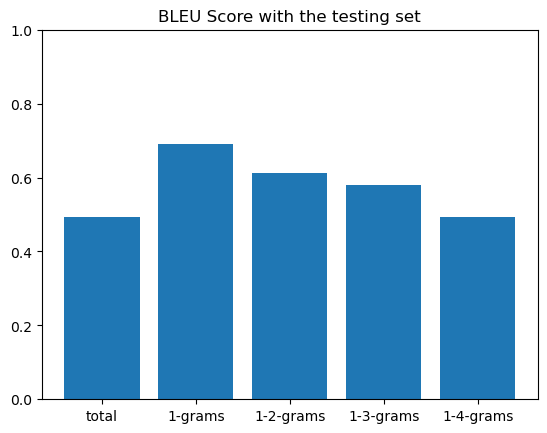

In [27]:
import matplotlib.pyplot as plt 
plt.bar(x = bleu_scores.keys(), height = bleu_scores.values())
plt.title("BLEU Score with the testing set")
plt.ylim((0,1))
plt.show()

In [ ]:
# import tensorflow as tf
# from transformers import TFAutoModelForSeq2SeqLM, AutoTokenizer

# # Load pre-trained model and tokenizer for translation
# model_name = "Helsinki-NLP/opus-mt-en-fr"
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = TFAutoModelForSeq2SeqLM.from_pretrained(model_name)

# french_hypothesis = []

# # English sentence to be translated
# #english_sentence = "Hello, how are you?"

# # Tokenize input sentence
# for premise in english_hypothesis[:3]:
#     # Tokenize input sentence
#     inputs = tokenizer(premise, truncation=True, padding=True, return_tensors="tf")

#     # Perform translation
#     outputs = model.generate(inputs["input_ids"])
#     french_ids = outputs[0].numpy()

#     # Decode translated sentence
#     french_sentence = tokenizer.decode(french_ids, skip_special_tokens=True)
#     french_hypothesis.append(french_sentence)

# # Print the translated sentences
# print("English hypothesis:", english_hypothesis[2])
# print("French hypothesis:", french_hypothesis[2])
# print()

In [ ]:
# #Splitting hypothesis
# english_train_hyp, english_test_hyp, french_train_hyp, french_test_hyp = train_test_split(english_hypothesis, french_hypothesis_ref, test_size = 0.2, random_state = 42)

In [ ]:
# #fine tuning hypothesis
# from transformers import TFAutoModelForSeq2SeqLM, AutoTokenizer, AdamWeightDecay
# import tensorflow as tf

# model_name = "Helsinki-NLP/opus-mt-en-fr"
# tokenizer = AutoTokenizer.from_pretrained(model_name)

# # Tokenize inputs and outputs
# inputs = tokenizer(english_train_hyp[:10000], truncation=True, padding=True, return_tensors="tf")
# outputs = tokenizer(french_train_hyp[:10000], truncation=True, padding=True, return_tensors="tf")

# # Create a function that will transform our dataset
# def map_func(input_ids, masks, labels):
#     return {'input_ids': input_ids, 'attention_mask': masks}, labels

# # Create tf.data.Datasets
# BATCH_SIZE = 16
# tf_train_dataset = tf.data.Dataset.from_tensor_slices((inputs['input_ids'], inputs['attention_mask'], outputs['input_ids']))
# tf_train_dataset = tf_train_dataset.map(map_func).shuffle(10000).batch(BATCH_SIZE)

# tf_test_dataset = tf.data.Dataset.from_tensor_slices((inputs['input_ids'], inputs['attention_mask'], outputs['input_ids']))
# tf_test_dataset = tf_test_dataset.map(map_func).batch(BATCH_SIZE)

# optimizer = AdamWeightDecay(learning_rate=2e-5, weight_decay_rate=0.01)

# model = TFAutoModelForSeq2SeqLM.from_pretrained(model_name)
# model.compile(optimizer=optimizer)
# model.fit(tf_train_dataset, validation_data=tf_test_dataset, epochs=3)


In [ ]:
# save_directory = "/kaggle/working"  # Specify the directory to save the model

# # Save the model and tokenizer
# model.save_pretrained(save_directory)
# tokenizer.save_pretrained(save_directory)

# print("Model saved successfully.")

In [ ]:
# from transformers import TFAutoModelForSeq2SeqLM, AutoTokenizer, AdamWeightDecay
# import tensorflow as tf

# model_name = "Helsinki-NLP/opus-mt-en-fr"
# tokenizer = AutoTokenizer.from_pretrained(model_name)

# # Tokenize inputs and outputs
# inputs = tokenizer(english_train[:10000], truncation=True, padding=True, return_tensors="tf")
# outputs = tokenizer(french_train[:10000], truncation=True, padding=True, return_tensors="tf")

# # Create a function that will transform our dataset
# def map_func(input_ids, masks, labels):
#     return {'input_ids': input_ids, 'attention_mask': masks}, labels

# # Create tf.data.Datasets
# BATCH_SIZE = 16
# tf_train_dataset = tf.data.Dataset.from_tensor_slices((inputs['input_ids'], inputs['attention_mask'], outputs['input_ids']))
# tf_train_dataset = tf_train_dataset.map(map_func).shuffle(10000).batch(BATCH_SIZE)

# tf_test_dataset = tf.data.Dataset.from_tensor_slices((inputs['input_ids'], inputs['attention_mask'], outputs['input_ids']))
# tf_test_dataset = tf_test_dataset.map(map_func).batch(BATCH_SIZE)

# optimizer = AdamWeightDecay(learning_rate=2e-5, weight_decay_rate=0.01)

# model = TFAutoModelForSeq2SeqLM.from_pretrained(model_name)
# model.compile(optimizer=optimizer)
# model.fit(tf_train_dataset, validation_data=tf_test_dataset, epochs=3)


In [ ]:
# from nltk.translate.bleu_score import corpus_bleu
# reference_french_premises = french_test[:2]

# print(len(reference_french_premises))
# print(len(french_predictions))
# # print('Ref sen', reference_french_premises)
# # print()
# # print('pred sen', french_predictions)

# tokenized_references = [[ref.split()] for ref in reference_french_premises]
# tokenized_candidates = [pred.split() for pred in french_predictions]

# # Print BLEU scores
# bleu_scores = {}
# bleu_scores['total'] = corpus_bleu(tokenized_references, tokenized_candidates)
# bleu_scores['1-grams'] = corpus_bleu(tokenized_references, tokenized_candidates, weights=(1.0, 0, 0, 0))
# bleu_scores['1-2-grams'] = corpus_bleu(tokenized_references, tokenized_candidates, weights=(0.5, 0.5, 0, 0))
# bleu_scores['1-3-grams'] = corpus_bleu(tokenized_references, tokenized_candidates, weights=(0.3, 0.3, 0.3, 0))
# bleu_scores['1-4-grams'] = corpus_bleu(tokenized_references, tokenized_candidates, weights=(0.25, 0.25, 0.25, 0.25))
# print("BLEU Scores:", bleu_scores)

In [ ]:
# import tensorflow as tf
# #from transformers import TFBertModel, BertTokenizer
# from transformers import TFAutoModelForSeq2SeqLM, AutoTokenizer
# from sklearn.model_selection import train_test_split
# from tensorflow.keras.losses import SparseCategoricalCrossentropy
# from tensorflow.keras.optimizers import Adam

# #saved_directory = "/kaggle/working"  # Specify the directory where the model was saved

# # model = TFBertModel.from_pretrained(saved_directory)
# # tokenizer = BertTokenizer.from_pretrained(saved_directory)

# model_name = "Helsinki-NLP/opus-mt-en-fr"
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = TFAutoModelForSeq2SeqLM.from_pretrained(model_name)

# french_predictions = []

# # Function to predict French sentences
# def predict_french_sentences(sentences):
#     # Tokenize the input sentences
#     tokenized_inputs = tokenizer(sentences, truncation=True, padding=True, return_tensors="tf")

#     # Generate predictions
#     predicted_ids = model.generate(tokenized_inputs.input_ids)
#     print(predicted_ids)
#     predicted_sentences = tokenizer.batch_decode(predicted_ids, skip_special_tokens=True)

#     return predicted_sentences

# # Example usage
# for i in range(10):
#     english_sentence = english_hypothesis[5001 + i]
#     predicted_french_sentence = predict_french_sentences(english_sentence)
#     french_predictions.append(predicted_french_sentence[0])
#     print("English sentence:", english_sentence)
#     print("Predicted French sentence:", predicted_french_sentence[0])

# # Print the predicted French sentence
# # print("English sentence:", english_sentence)
# # print("Predicted French sentence:", predicted_french_sentence)

In [ ]:
# from nltk.translate.bleu_score import corpus_bleu
# reference_french_premises = french_premises_ref[500:550]

# print(len(reference_french_premises))
# print(len(french_predictions))
# # print('Ref sen', reference_french_premises)
# # print()
# # print('pred sen', french_predictions)

# tokenized_references = [[ref.split()] for ref in reference_french_premises]
# tokenized_candidates = [pred.split() for pred in french_predictions]

# # Print BLEU scores
# bleu_scores = {}
# bleu_scores['total'] = corpus_bleu(tokenized_references, tokenized_candidates)
# bleu_scores['1-grams'] = corpus_bleu(tokenized_references, tokenized_candidates, weights=(1.0, 0, 0, 0))
# bleu_scores['1-2-grams'] = corpus_bleu(tokenized_references, tokenized_candidates, weights=(0.5, 0.5, 0, 0))
# bleu_scores['1-3-grams'] = corpus_bleu(tokenized_references, tokenized_candidates, weights=(0.3, 0.3, 0.3, 0))
# bleu_scores['1-4-grams'] = corpus_bleu(tokenized_references, tokenized_candidates, weights=(0.25, 0.25, 0.25, 0.25))
# print("BLEU Scores:", bleu_scores)

In [ ]:
# import matplotlib.pyplot as plt 
# plt.bar(x = bleu_scores.keys(), height = bleu_scores.values())
# plt.title("BLEU Score with the testing set")
# plt.ylim((0,1))
# plt.show()